In [158]:
import os
from PIL import Image, ImageOps
import torchvision.transforms as tt
import random
import torchvision.transforms.functional as F
import numpy as np
from tqdm import tqdm

In [164]:
def augment_dataset(bg_path, bears_path, masks_path, save_path):
    bgs = load_imgs(bg_path)
    bears = load_imgs(bears_path, mode="RGBA")
    masks = load_imgs(masks_path, mode="RGBA")
    bears_save_path = os.path.join(save_path, "bears")
    masks_save_path = os.path.join(save_path, "masks")
    i = 0
    with tqdm(total=3*3*4*len(bears)) as pbar:
        for it in range(3):
            for k in range(4):
                for mirror in [None, ImageOps.mirror, ImageOps.flip]:
                    for bear, bear_mask in zip(bears, masks):
                        if mirror:
                            bear = mirror(bear)
                            bear_mask = mirror(bear_mask)
                        bear = bear.rotate(90*k, expand=True)
                        bear_mask = bear_mask.rotate(90*k, expand=True)
                        bg_img = bgs[random.randint(0, len(bgs)-1)]
                        left = random.randint(0, bg_img.size[0] - bear.size[0])
                        top = random.randint(0, bg_img.size[1] - bear.size[1])
                        coords = (left, top, left + bear.size[0], top + bear.size[1])
                        bg_img = bg_img.crop(coords)
                        bg_arr = np.array(bg_img)
                        bear_arr = np.array(bear)
                        assert bear_arr[:, :, :3].shape == bg_arr[:, :, :3].shape
                        for x in range(bear_arr.shape[0]):
                            for y in range(bear_arr.shape[1]):
                                if bear_arr[x, y, 3] == 255:
                                    bg_arr[x, y, :3] = 0.2 * bg_arr[x, y, :3] + 0.8 * bear_arr[x, y, :3]
                        bg_img = Image.fromarray(bg_arr)
                #         bg_img.paste(bear)
                        bg_mask = Image.new("RGB", bear.size)
                        bg_mask.paste(bear_mask)
                        assert bear.size == bear_mask.size
                        os.makedirs(bears_save_path, exist_ok=True)
                        os.makedirs(masks_save_path, exist_ok=True)
                        bg_img.save(os.path.join(bears_save_path, f"{i}.PNG"))
                        bg_mask.save(os.path.join(masks_save_path, f"{i}.PNG"))
                        i += 1
                        pbar.update(1)

In [165]:
augment_dataset('../input/arcticbg', '../input/arcticbears640px/only_bears/bears', '../input/arcticbears640px/only_bears/masks', './augmented')

100%|██████████| 1260/1260 [17:38<00:00,  1.19it/s]


In [66]:
[1, 2, 3][:3]

[1, 2, 3]

In [143]:
def load_imgs(path, mode="RGB"):
    return [Image.open(os.path.join(path,  file)).convert(mode) for file in sorted(os.listdir(path))]

In [144]:
augmented = load_imgs('./augmented/bears')

In [145]:
augmented_masks = load_imgs('./augmented/masks')

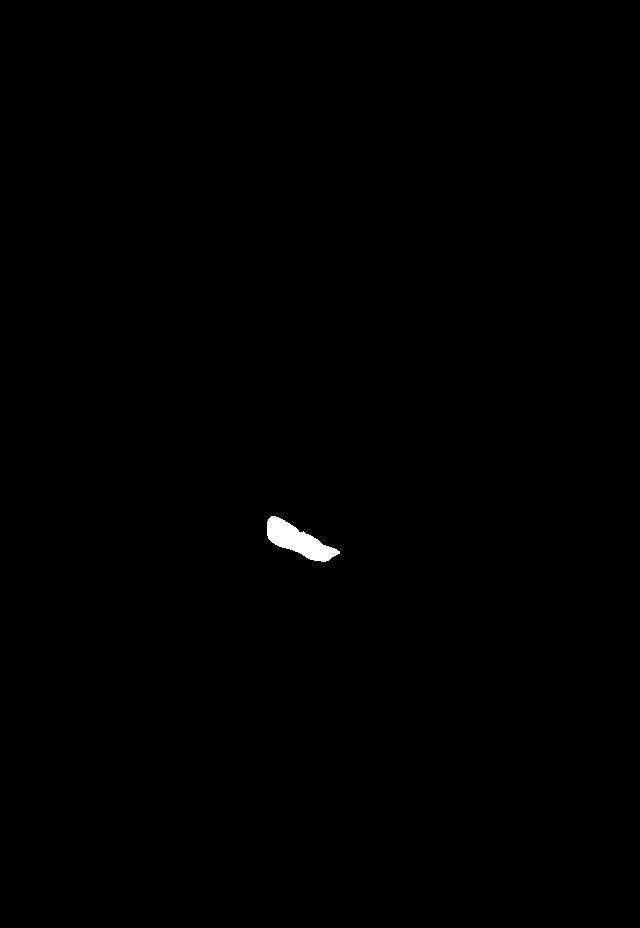

In [146]:
augmented_masks[4]

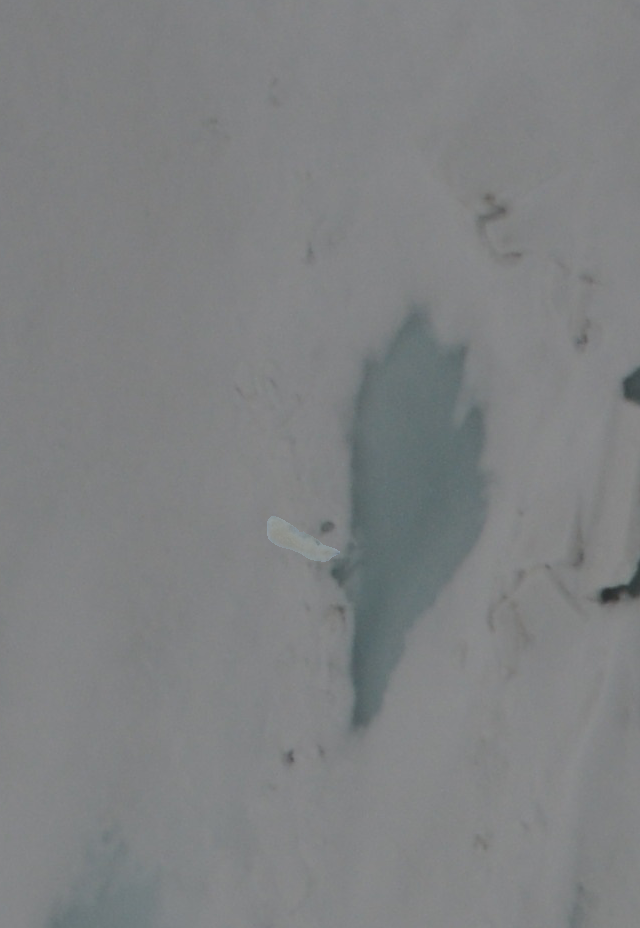

In [147]:
augmented[4]

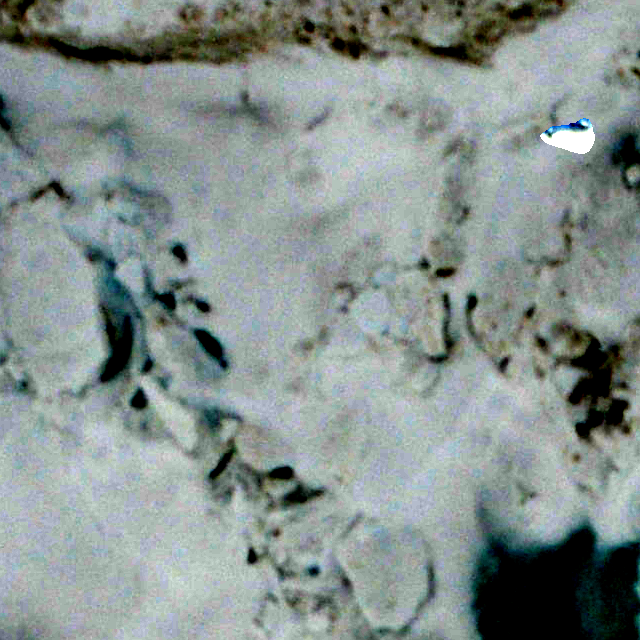

In [123]:
img = F.adjust_contrast(augmented[0], 8)
img